In [2]:
%matplotlib inline

# Exploring the ideas of Random Matrix theory
### Dataset : BCI Motor Imagery IV 2a
Remember to install the following packages
- pyRiemann
- MNE
- Those that come with Anaconda (matplotlib, numpy, sklearn, etc)

In [3]:
# import the basic python packages
import numpy as np
import matplotlib.pyplot as plt

# import the pyRiemann package and its modules
from pyriemann.utils.distance import distance_riemann, distance_euclid
from pyriemann.estimation import Covariances

# import the utilities modules
from utilities.data_handler import get_bci_mi_dataset, get_alpha_waves_dataset
from utilities.data_process import make_distance_matrix, make_laplacian_matrix

The examples in this notebook come from a dataset with EEG signals from BCI. The experimental paradigm is **not important**, all we need to know is that each experimental trial belongs to one of four classes. We have 72 trials for each of 4 classes.

The signals are multivariate time-series and are **assumed** Gaussian and wide-sense stationary. This means that each trial can be denoted as $X_i \in \mathbb{R}^{n \times T}$ ($n$ is the number of electrodes, $T$ is the number of time samples) and its statistics can be described by a mean $\mu_i$ and a covariance matrix $C_i$. 

NB: the **pre-processing** of the signals involves a bandpass filtering between 8 and 35 Hz (where there is actual neurophysiological information) which ends up zeroing the mean of the time series always to zero, so $\mu_i = 0$ for all trials.

In [29]:
# get the BCI dataset and select just two classes
X, y = get_bci_mi_dataset(subject=3)
sel = (y == 1) | (y == 2) 
X, y = X[sel], y[sel]
idx = np.concatenate([np.where(y == 1)[0], np.where(y == 2)[0]]) 
X, y = X[idx], y[idx]

# estimate the covariance matrix associate to each trial
covs = Covariances().fit_transform(X)

We'll start the analysis by calculating the matrix with all pairwise distances between the trials. We consider two different distances, one that simply takes the Euclidean distance $\delta_E$ between the samples of each trial $X_i$ and $X_j$,

$$
\delta^2_E(X_i, X_j) = \|X_i - X_j\|_F^2,
$$

and the Riemannian distance $\delta_R$ between the covariance matrices $C_i$ and $C_j$ associated to the trials,

$$
\delta^2_R(X_i, X_j) = \|\log(C_i^{-1/2}C_jC_i^{-1/2})\|_F^2.
$$


In [8]:
dm_euc = make_distance_matrix(points=X, distance=distance_euclid)
dm_rie = make_distance_matrix(points=covs, distance=distance_riemann)

Plot the heat maps showing the patterns for the distance matrices. One would **expect** to see two blocks of values, since the trials from same class should be near to each other

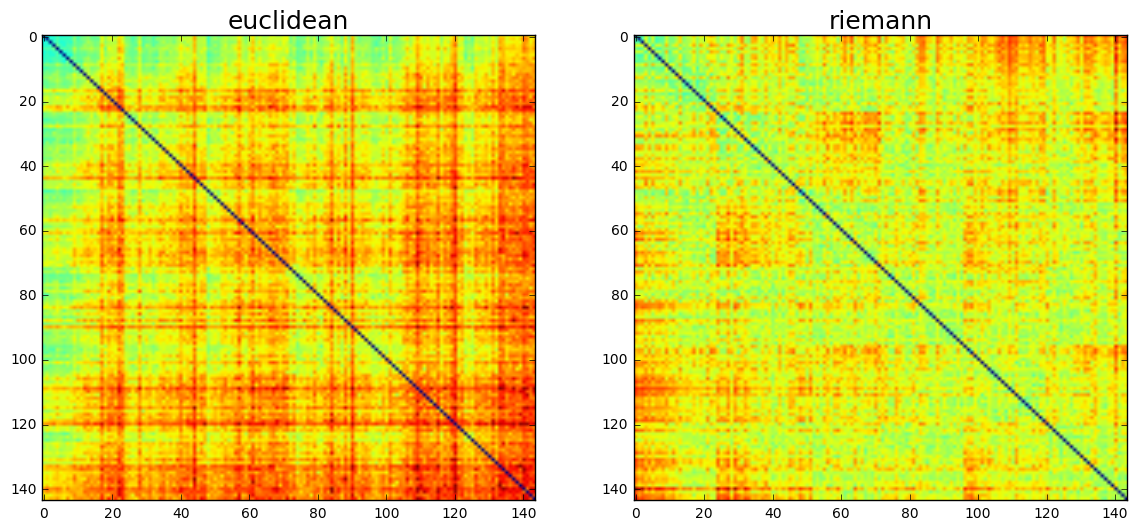

In [36]:
fig, ax = plt.subplots(facecolor='white', figsize=(14,6), ncols=2)
for axi, dmatrix, label in zip(ax, [dm_euc, dm_rie], ['euclidean', 'riemann']):
    axi.imshow(dmatrix, aspect='auto')
    axi.set_title(label, fontsize=18)

Plotting the **histogram** of both distance matrices. Note that they are both unimodal, which seems in accordance with the $\tau$ result from Romain's paper and also what we say in the heat maps above

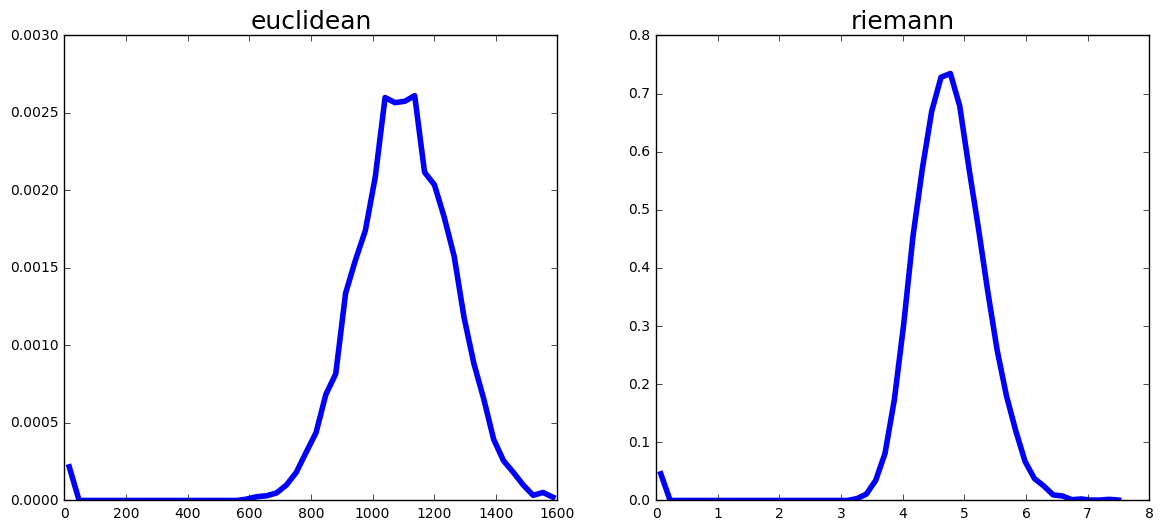

In [15]:
fig, ax = plt.subplots(facecolor='white', figsize=(14,6), ncols=2)
for axi, dmatrix, label in zip(ax, [dm_euc, dm_rie], ['euclidean', 'riemann']):
    hist, bins = np.histogram(dmatrix.flatten(), density=True, bins=50)
    axi.plot((bins[1:]+bins[:-1])/2, hist, lw=4.0)
    axi.set_title(label, fontsize=18)

Now we calculate the Laplacian matrix for each dataset to get their **spectral** embeddings

In [24]:
# loop through the distance matrices
u = []
L = []
for dmatrix in [dm_euc, dm_rie]:

    # heuristic for the eps parameter in the gaussian kernel
    eps = 2*np.median(dmatrix)**2
    K = np.exp(-dmatrix**2/eps)

    # make the Laplacian matrix and decompose it
    Ld = make_laplacian_matrix(kernel_matrix=K)
    ud,s,v = np.linalg.svd(Ld)

    L.append(Ld)
    u.append(ud)
    
u_euc, u_rie = u    
L_euc, L_rie = L

Scatter plots with the spectral embedding of each type of distance matrix 

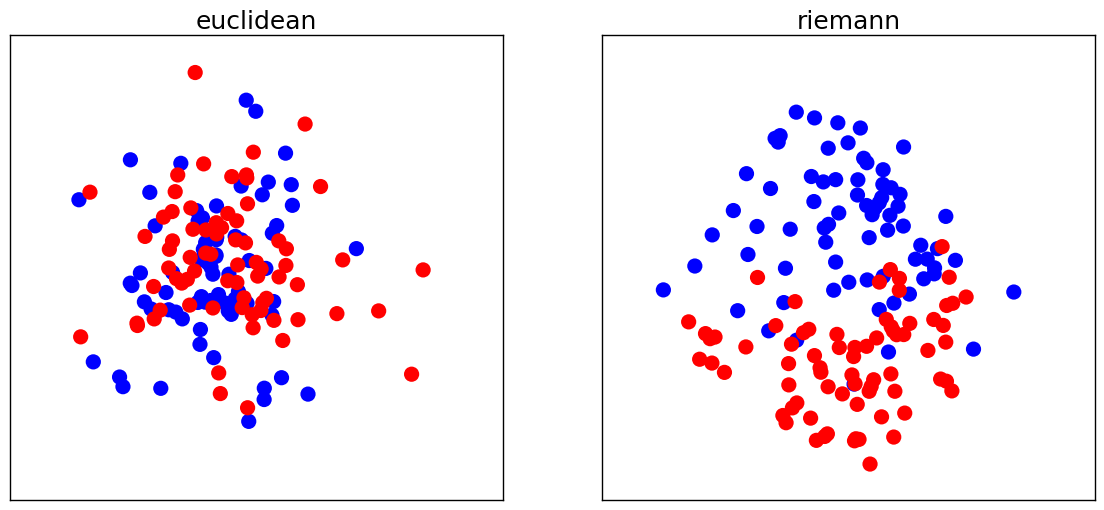

In [25]:
fig, ax = plt.subplots(facecolor='white', figsize=(14,6), ncols=2)
for axi, uspec, label in zip(ax, [u_euc, u_rie], ['euclidean', 'riemann']):
    dimx = 1; dimy = 2
    axi.scatter(uspec[y == 1, dimx], uspec[y == 1, dimy], s=120, edgecolor='none', facecolor='b')
    axi.scatter(uspec[y == 2, dimx], uspec[y == 2, dimy], s=120, edgecolor='none', facecolor='r')
    axi.set_xticks([])
    axi.set_yticks([]) 
    axi.set_title(label, fontsize=18)